## Data Preprocessing and Visualization Step -1



#### For detecting people if they are wearing a mask or not, our model needs to be trained with the images where people's faces are annotated and labelled for both the categories. For us to train the model, data has been procured from multiple sources . In this notebook , we will preprocess one of the data sources to a particular format and visualize the images for "Mask" and "No Mask".

## a) Data Preprocessing

In [1]:
# Importing Relevant Libraries
import pandas as pd
import os
import cv2
import glob
import xmltodict
from collections import OrderedDict
import matplotlib.pyplot as plt

##### Generating an annotation file from the list of xmls in the "labels" folder which contain the attributes for all the images present in the "images" folder
##### Attributes of a particular image : Bounding box dimensions in the form of xmin,ymin,xmax,ymax (coordinates of top left and bottom right rectangle of the annotated faces), and labels 

In [2]:
# Getting the path of the images and labels 
# Output : image path and label path
def get_path(image_name,home_path):
    
    image_path = home_path + 'images/' + image_name
    
    if image_name[-4:] == 'jpeg':
        label_name = image_name[:-5] + '.xml'
    else:
        label_name = image_name[:-4] + '.xml'
    
    label_path = home_path + 'labels/' + label_name
        
    return  image_path, label_path


In [7]:
# Parsing the xmls in the label path and get the relevant attributes for the model 
# Output : result - Dimensions of the bounding box
#          size - width and height of the image
def parse_xml(label_path):
    #print(label_path)
    
    x = xmltodict.parse(open(label_path , 'rb'))
    item_list = x['annotation']['object']
    
    # when image has only one bounding box
    if not isinstance(item_list, list):
        item_list = [item_list]
        
    result = []
    
    for item in item_list:
        ans = item['name']
        bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                  (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
        result.append((ans, bndbox))
    
    size = [int(x['annotation']['size']['width']), 
            int(x['annotation']['size']['height'])]
    
    return result, size


In [8]:
# Generating separate rows for each annotation in a single image 
def row_gen(image_path,bndbox,ans):
    x1 = bndbox[0][0]
    x2 = bndbox[1][0]
    y1 = bndbox[0][1]
    y2 = bndbox[1][1]
    return f'{image_path},{x1},{y1},{x2},{y2},{ans}'

In [9]:
# Creating the annotation file and stored as csv with the relevant columns.
def create_csv():

    img_list = os.listdir('/data/logo_detection/Hackathon/raw_data/images')
    home_path = '/data/logo_detection/Hackathon/raw_data/'
    with open('/data/logo_detection/Hackathon/processed_files/annotation.txt','w+') as a:
        for i in img_list:
            image_path,label_path = get_path(i,home_path)
            if (label_path == '/data/logo_detection/Hackathon/raw_data/labels/.ipynb_checkpo.xml'):
                continue
            results,size = parse_xml(label_path)
            for result in results:
                (ans,bndbox) = result
                annot = row_gen(image_path,bndbox,ans)
                a.write(annot+'\n')
            
    ann_txt = pd.read_csv(r'/data/logo_detection/Hackathon/processed_files/annotation.txt',header=None)     
    ann_txt.columns = ['image_path','x1','y1','x2','y2','class_name']
    ann_txt.to_csv(r'/data/logo_detection/Hackathon/processed_files/annotation_1.csv',index=None )
    

In [10]:
create_csv()

##### Trasforming the columns for the Input for our model
##### Required columns for our model 'class_id','center-x','center-y','width','height' (all Normalised)

In [12]:
df_1=pd.read_csv('/data/logo_detection/Hackathon/processed_files/annotation_1.csv')

In [13]:
# Getting the shape of the image if it exists in the folder
filenames = list(df_1['image_path'])
len(filenames)
imageshape={}
for i in filenames:
    if os.path.exists(i):
        im= cv2.imread(i)
        imageshape.update({i:im.shape})
        
    else:
        pass

In [14]:
df_1['image_shape'] = df_1['image_path'].map(imageshape)
df_1.head()

,image_path,x1,y1,x2,y2,class_name,image_shape
0,/data/logo_detection/Hackathon/raw_data/images...,138,93,199,162,good,"(600, 1000, 3)"
1,/data/logo_detection/Hackathon/raw_data/images...,499,189,522,216,good,"(600, 1000, 3)"
2,/data/logo_detection/Hackathon/raw_data/images...,684,299,725,335,good,"(600, 1000, 3)"
3,/data/logo_detection/Hackathon/raw_data/images...,792,151,843,205,good,"(600, 1000, 3)"
4,/data/logo_detection/Hackathon/raw_data/images...,581,152,595,170,good,"(600, 1000, 3)"


In [15]:
# Getting the height and width of the annotations from x and y coordinates
df_1['width']= df_1['x2']-df_1['x1']
df_1['height']=df_1['y2']-df_1['y1']

In [16]:
# Splitting the image_shape tuple into three different columns
df_1[['image_height','image_width','image_channels']]=pd.DataFrame(df_1['image_shape'].tolist(),index=df_1.index)
df_1['filename']= df_1['image_path'].map(lambda x: x.split('/')[-1])

# Getting the center coordinates of the annotations from x and y coordinates
df_1['center-x']= df_1['x1']+(df_1['width']/2)
df_1['center-y']= df_1['y1']+(df_1['height']/2)

In [17]:
#Normalising the height and width of Bounding Box
df_1['normalised_height']= (df_1['height']/df_1['image_height'])
df_1['normalised_width']= (df_1['width']/df_1['image_width'])
df_1['center-x']= df_1['center-x']/df_1['image_width']
df_1['center-y'] = df_1['center-y']/df_1['image_height']


#Selecting relevant columns
df_1 = df_1[['filename','class_name','center-x','center-y','normalised_width','normalised_height']]
df_1.head()

,filename,class_name,center-x,center-y,normalised_width,normalised_height
0,4673871.jpg,good,0.1685,0.212500,0.061,0.115
1,4673871.jpg,good,0.5105,0.337500,0.023,0.045
2,4673871.jpg,good,0.7045,0.528333,0.041,0.060
3,4673871.jpg,good,0.8175,0.296667,0.051,0.090
4,4673871.jpg,good,0.5880,0.268333,0.014,0.030


In [18]:
path= '/data/logo_detection/Hackathon/processed_files/annotation_1.csv'
df_1.to_csv(path,index=None)

## b) Visualization

In [37]:
def visualize_image(image_name, bndbox=True):
    home_path = '/data/logo_detection/Hackathon/raw_data/'
    image_path, label_path = get_path(image_name,home_path)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'good':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'none' or name =="bad":
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)

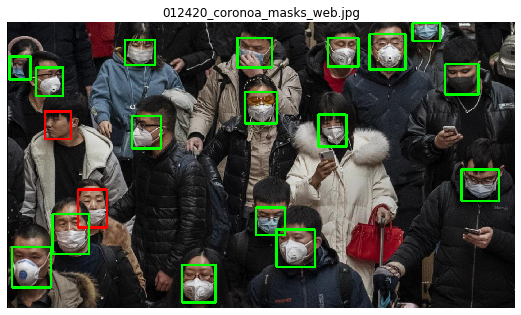

In [38]:
visualize_image('012420_coronoa_masks_web.jpg')

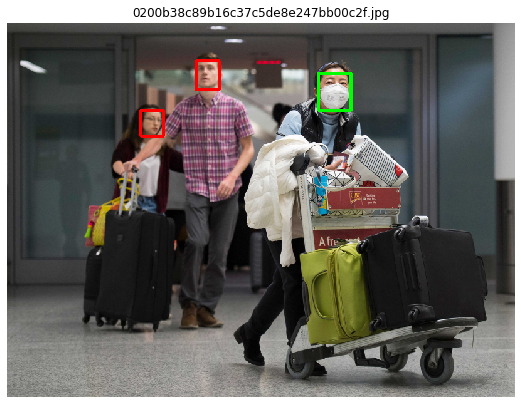

In [39]:
visualize_image('0200b38c89b16c37c5de8e247bb00c2f.jpg')

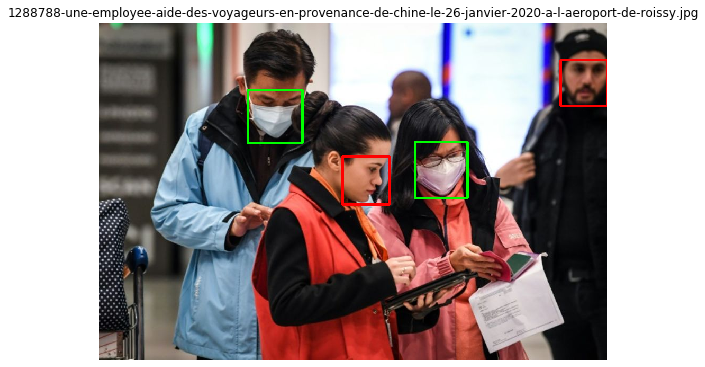

In [40]:
visualize_image('1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy.jpg')

### In the above images, people who are wearing masks properly are marked with "Green" boundary and people who are not wearing masks are marked with "Red" Boundary for visualization purpose.

### We have incorporated this data as part of our training dataset  